In [107]:
%matplotlib notebook
import io
import sys
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
# read in the training data
trainImages = io.open('train-images.idx3-ubyte', 'rb')
trainLabels = io.open('train-labels.idx1-ubyte', 'rb')

In [2]:
magic = int.from_bytes(trainImages.read(4), byteorder='big')
if magic != 2051:
    sys.exit('Wrong magic number for train-images.idx3-ubyte')
    
magic = int.from_bytes(trainLabels.read(4), byteorder='big')
if magic != 2049:
    sys.exit('Wrong magic number for train-labels.idx3-ubyte')

imageNum = int.from_bytes(trainImages.read(4), byteorder='big')
labelNum = int.from_bytes(trainLabels.read(4), byteorder='big')

num = min(imageNum, labelNum)

# dimensions of each image
rowNum = int.from_bytes(trainImages.read(4), byteorder='big')
colNum = int.from_bytes(trainImages.read(4), byteorder='big')

images = np.zeros(num*colNum*rowNum).reshape(num, colNum*rowNum)
for i in range(num):
    for j in range(colNum*rowNum):
        images[i, j] = int.from_bytes(trainImages.read(1), byteorder='big', signed=False)

labels = np.zeros(num)
for i in range(num):
    labels[i] = int.from_bytes(trainLabels.read(1), byteorder='big', signed=False)

trainImages.close()
trainLabels.close()

In [17]:
# read in the test data
testImages = io.open('t10k-images.idx3-ubyte', 'rb')
testLabels = io.open('t10k-labels.idx1-ubyte', 'rb')

In [18]:
magicT = int.from_bytes(testImages.read(4), byteorder='big')
if magicT != 2051:
    sys.exit('Wrong magic number for t10k-images.idx3-ubyte')
    
magicT = int.from_bytes(testLabels.read(4), byteorder='big')
if magicT != 2049:
    sys.exit('Wrong magic number for t10k-labels.idx3-ubyte')

imageNumT = int.from_bytes(testImages.read(4), byteorder='big')
labelNumT = int.from_bytes(testLabels.read(4), byteorder='big')

numT = min(imageNumT, labelNumT)

# dimensions of each image
rowNumT = int.from_bytes(testImages.read(4), byteorder='big')
colNumT = int.from_bytes(testImages.read(4), byteorder='big')

imagesT = np.zeros(numT*colNumT*rowNumT).reshape(numT, colNumT*rowNumT)
for i in range(numT):
    for j in range(colNumT*rowNumT):
        imagesT[i, j] = int.from_bytes(testImages.read(1), byteorder='big', signed=False)

labelsT = np.zeros(numT)
for i in range(numT):
    labelsT[i] = int.from_bytes(testLabels.read(1), byteorder='big', signed=False)

testImages.close()
testLabels.close()

# display the image specified by index

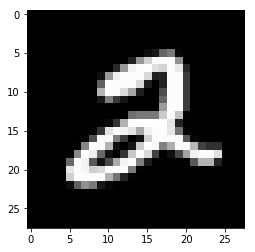

2.0


In [3]:
index = 5
sample = images[index].reshape(rowNum, colNum)
plt.imshow(sample, cmap='gray')
plt.show()
print(labels[index])

# show the intensity distribution of pixels

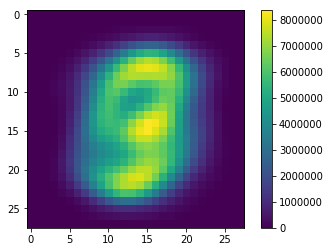

In [4]:
merge = np.zeros(rowNum*colNum)
for i in range(60000):
    merge = merge + images[i]

plt.imshow(merge.reshape(rowNum, colNum))
plt.colorbar()
plt.title('')
plt.show()

# SVD decomposition result

In [5]:
U, S, VT = np.linalg.svd(images, full_matrices=False)

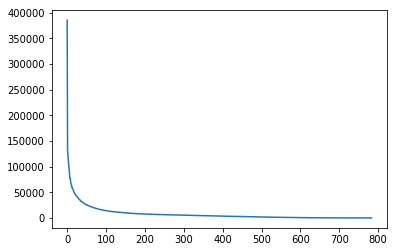

In [6]:
plt.plot(S)

# Using $w=(A^TA+\lambda I)^{-1}A^Td$ directly with $\lambda=0.1$

In [28]:
start = time.time()
lmda = 0.1
w = np.linalg.inv(images.transpose()@images+lmda*np.identity(rowNum*colNum))@images.transpose()@labels
end = time.time()
print('Total computation time by using inversion of matrice directly: ', (end - start))

Total computation time by using inversion of matrice directly:  1.777195692062378


# Display the distribution of weights

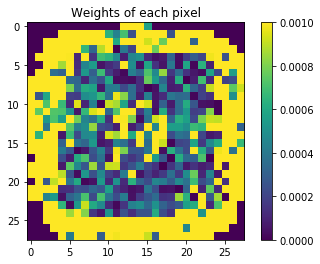

In [29]:
plt.imshow(np.absolute(w.reshape(rowNum, colNum)), vmax=0.001)
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

In [30]:
labelsHat = np.around(imagesT@w)
errorRate = np.sum(labelsHat == labelsT) / numT
print('error rate on the test set is: ', errorRate)

error rate on the test set is:  0.2433


# Error rate vs. number of preserved singular values

Text(0,0.5,'error rate')

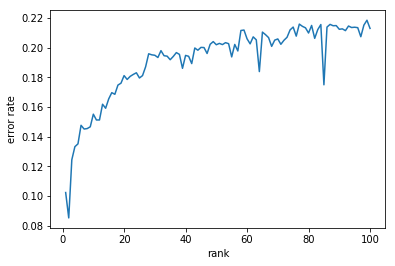

In [39]:
s = np.zeros((S.shape[0], S.shape[0]))
w = np.zeros((colNum*rowNum, 100))
errorRate = np.zeros(100)
lmda = 0.1

for i in range(100):
    s[i, i] = S[i]
    imagesReduced = U@s@VT
    w[:,i] = np.linalg.inv(imagesReduced.transpose()@imagesReduced+lmda*np.identity(rowNum*colNum))@imagesReduced.transpose()@labels
    
    labelsHat = np.around(imagesT@w[:,i])
    errorRate[i] = np.sum(labelsHat == labelsT) / numT

plt.plot(np.arange(1,101), errorRate)
plt.xlabel('rank')
plt.ylabel('error rate')

Text(0,0.5,'error rate')

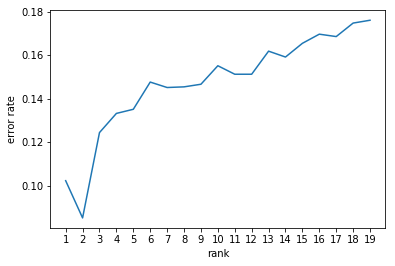

In [43]:
plt.plot(np.arange(1,20), errorRate[0:19])
plt.xticks(np.arange(1, 20))
plt.xlabel('rank')
plt.ylabel('error rate')

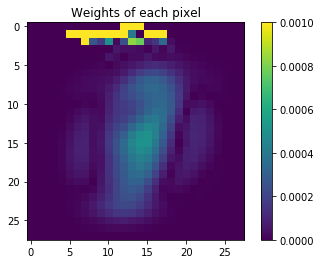

In [57]:
plt.imshow(np.absolute(w[:,1].reshape(rowNum, colNum)), vmax=0.001)
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

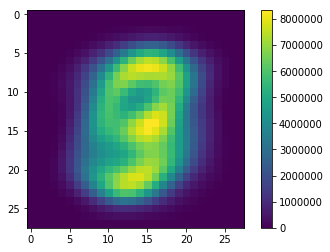

In [62]:
s = np.zeros((S.shape[0], S.shape[0]))
s[0,0] = S[0]
s[1,1] = S[1]
imagesReduced = U@s@VT

merge = np.zeros(rowNum*colNum)
for i in range(60000):
    merge = merge + imagesReduced[i]

plt.imshow(merge.reshape(rowNum, colNum))
plt.colorbar()
plt.show()

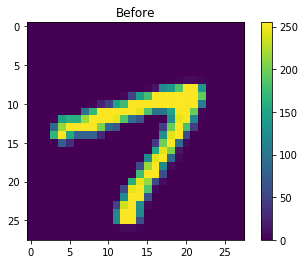

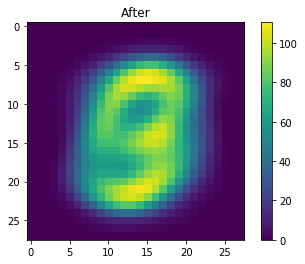

7.0


In [68]:
index = 101
sample = images[index].reshape(rowNum, colNum)
plt.imshow(sample)
plt.colorbar()
plt.title('Before')
plt.show()

sample = imagesReduced[index].reshape(rowNum, colNum)
plt.imshow(sample)
plt.colorbar()
plt.title('After')
plt.show()
print(labels[index])

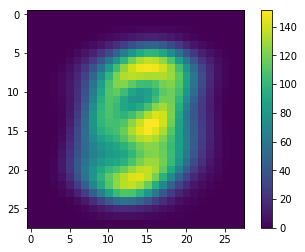

5.0


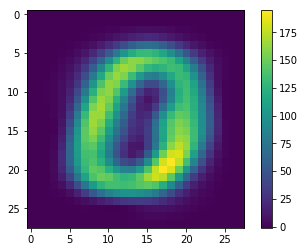

0.0


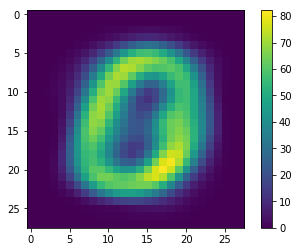

4.0


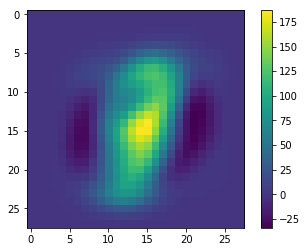

1.0


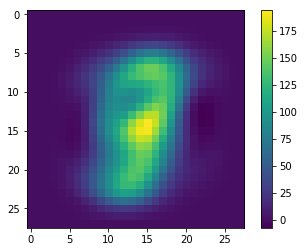

9.0


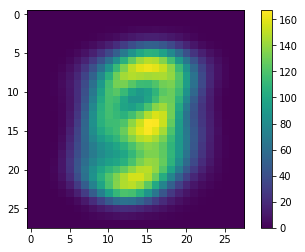

2.0


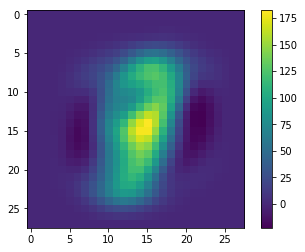

1.0


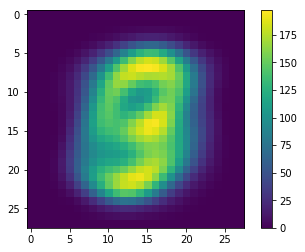

3.0


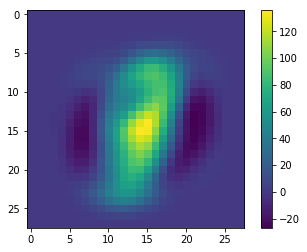

1.0


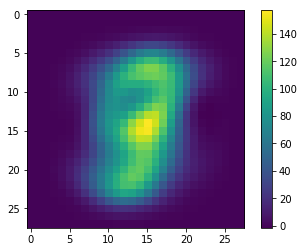

4.0


In [70]:
# display some images after the rank=2 approximation
for i in range(10):
    sample = imagesReduced[i].reshape(rowNum, colNum)
    plt.imshow(sample)
    plt.colorbar()
    plt.show()
    print(labels[i])

# Using rank=2 approximation and tuning the parameter $\lambda=2^k, k = -4, -3, ..., 3, 4$

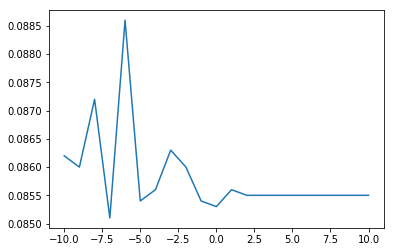

In [81]:
s = np.zeros((S.shape[0], S.shape[0]))
s[0,0] = S[0]
s[1,1] = S[1]
errorRate = np.zeros(21)
imagesReduced = U@s@VT
k = np.arange(-10,11, dtype=float)

for i in range(21):
    lmda = 2**(k[i])
    w_2 = np.linalg.inv(imagesReduced.transpose()@imagesReduced+lmda*np.identity(rowNum*colNum))@imagesReduced.transpose()@labels
    
    labelsHat = np.around(imagesT@w_2)
    errorRate[i] = np.sum(labelsHat == labelsT) / numT

plt.plot(k, errorRate)

# search on two dimensions, $\lambda$ and \#($\sigma_i$)

In [82]:
s = np.zeros((S.shape[0], S.shape[0]))
errorRate = np.zeros((20, 21))
k = np.arange(-10,11, dtype=float)

for i in range(20):
    s[i,i] = S[i]
    imagesReduced = U@s@VT
    for j in range(21):
        lmda = 2**(k[j])
        w = np.linalg.inv(imagesReduced.transpose()@imagesReduced+lmda*np.identity(rowNum*colNum))@imagesReduced.transpose()@labels
        
        labelsHat = np.around(imagesT@w)
        errorRate[i][j] = np.sum(labelsHat == labelsT) / numT

<IPython.core.display.Javascript object>


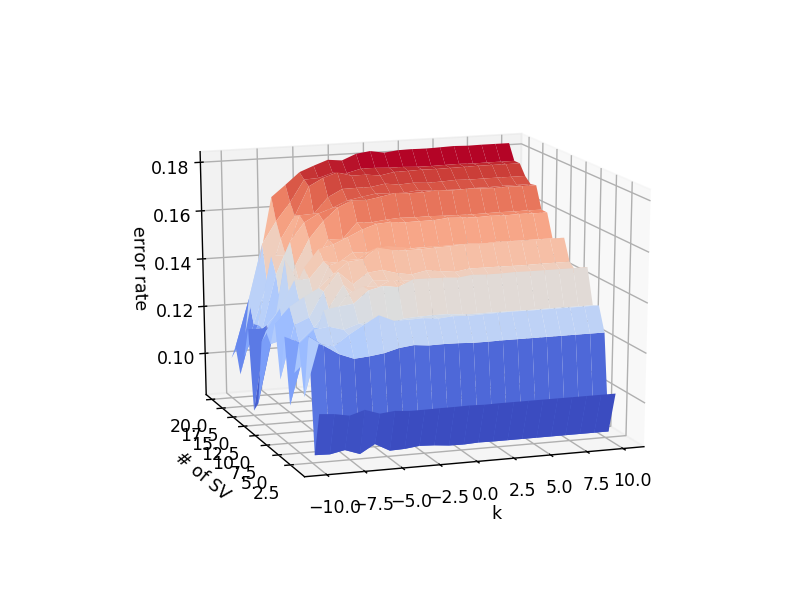

In [109]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(k, np.arange(1, 21))
Z = errorRate

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

ax.set_xlabel('k')
ax.set_ylabel('# of SV')
ax.set_zlabel('error rate')
plt.show()

In [114]:
np.where(errorRate == np.min(errorRate))

(array([14], dtype=int64), array([0], dtype=int64))

In [115]:
print(errorRate[14, 0])

0.0843
